In [1]:
import os
import time
import xarray as xr
import rioxarray as rxr
from rasterio.enums import Resampling
from rasterio import Affine
from urllib.request import urlretrieve
from osgeo import gdal, osr
import numpy as np
import cftime as cf
import datetime

In [2]:
# vars
sdate = datetime.datetime(2020, 1, 1)
edate = datetime.datetime(2050, 1, 1)
github_path = 'https://github.com/rubisco-sfa/ILAMB-Data/blob/msteckler/GFW/convert.py'

# data sources
remote_data = 'https://www.arcgis.com/sharing/rest/content/items/f950ea7878e143258a495daddea90cc0/data'
local_data = 'sequestration_rate_mean_aboveground_full_extent_Mg_C_ha_yr.tif'
remote_u_data = 'https://www.arcgis.com/sharing/rest/content/items/d28470313b8e443aa90d5cbcd0f74163/data'
local_u_data = 'sequestration_error_ratio_layer_in_full_extent.tif'

In [3]:
# Open the input raster
download_stamp = time.strftime('%Y-%m-%d', time.localtime(os.path.getmtime(local_data)))
if not os.path.isfile(local_data):
    urlretrieve(remote_data, local_data)
data = rxr.open_rasterio(local_data, band_as_variable=True)

# ensure data is not projected and is wgs84
epsg_code = int(data.rio.crs.to_epsg())
if epsg_code != 4326:
    data = data.rio.reproject(crs='EPSG:4326')

In [4]:
# resample to 0.5 degrees
target_res = 0.5
resampled_data = data.coarsen(x=(int(target_res / abs(data.rio.resolution()[0]))),
                              y=(int(target_res / abs(data.rio.resolution()[1])))).mean()

In [5]:
resampled_data.dims

FrozenMappingWarningOnValuesAccess({'y': 360, 'x': 720})

In [6]:
ds = resampled_data.rename({'x': 'lon', 'y': 'lat', 'band_1':'c_uptake_rate'})

In [7]:
# numpy array of time bounds
tb_arr = np.asarray([
    [cf.DatetimeNoLeap(sdate.year, sdate.month, sdate.day)],
    [cf.DatetimeNoLeap(edate.year, edate.month, edate.day)]
]).T

In [8]:
# xarray data array of time bounds
tb_da = xr.DataArray(tb_arr, dims=('time', 'nv'))

In [9]:
# add time dimension and time bounds attribute
ds = ds.expand_dims(time=tb_da.mean(dim='nv'))
ds['time_bounds'] = tb_da

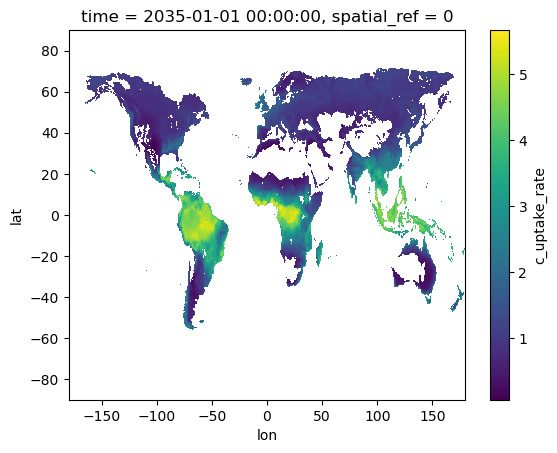

In [10]:
ds_t0 = ds.isel(time=0)
ds['c_uptake_rate'].plot()

In [11]:
# edit time attributes
ds['time'].encoding['units'] = 'days since 2020-01-01'
ds['time'].attrs['bounds'] = 'time_bounds'

In [12]:
# edit variable attributes
ds['c_uptake_rate'].attrs = {
    'long_name': "mean aboveground biomass carbon accumulation rate",
    'units': 'Mg ha-1 yr-1'}

In [13]:
# edit global attributes
generate_stamp = time.strftime('%Y-%m-%d', time.localtime(os.path.getmtime(local_data)))
ds.attrs = {
    'title':'Carbon accumulation potential from natural forest regrowth in forest and savanna biomes',
    'institution':'Global Forest Watch',
    'source':'Ensemble of 100 random forest models using ground measurements and 66 co-located environmental covariate layers',
    'history':f"""
    {download_stamp}: downloaded source from {remote_data};
    {generate_stamp}: resampled to 0.5 degree resolution and created CF-compliant meta-data in {github_path};""",
    'references': """
    @article{Cook-Patton2020,
      author  = {Susan C. Cook-Patton, Sara M. Leavitt, David Gibbs, Nancy L. Harris, Kristine Lister, Kristina J. Anderson-Teixeira, Russell D. Briggs, Robin L. Chazdon, Thomas W. Crowther, Peter W. Ellis, Heather P. Griscom, Valentine Herrmann, Karen D. Holl, Richard A. Houghton, Cecilia Larrosa, Guy Lomax, Richard Lucas, Palle Madsen, Yadvinder Malhi, Alain Paquette, John D. Parker, Keryn Paul, Devin Routh, Stephen Roxburgh, Sassan Saatchi, Johan van den Hoogen, Wayne S. Walker, Charlotte E. Wheeler, Stephen A. Wood, Liang Xu & Bronson W. Griscom},
      title   = {Mapping carbon accumulation potential from global natural forest regrowth},
      journal = {Nature},
      year    = {2020},
      volume  = {585},
      pages   = {545--550}
      doi     = {https://doi.org/10.1038/s41586-020-2686-x}}""",
    'comment':''}

In [21]:
ds

<xarray.Dataset> Size: 1MB
Dimensions:        (time: 1, lat: 360, lon: 720, nv: 2)
Coordinates:
  * time           (time) object 8B 2035-01-01 00:00:00
  * lon            (lon) float64 6kB -179.8 -179.3 -178.8 ... 178.7 179.2 179.7
  * lat            (lat) float64 3kB 89.75 89.25 88.75 ... -88.75 -89.25 -89.75
Dimensions without coordinates: nv
Data variables:
    c_uptake_rate  (time, lat, lon) float32 1MB nan nan nan nan ... nan nan nan
    time_bounds    (time, nv) object 16B 2020-01-01 00:00:00 2050-01-01 00:00:00
Attributes:
    title:        Carbon accumulation potential from natural forest regrowth ...
    institution:  Global Forest Watch
    source:       Ensemble of 100 random forest models using ground measureme...
    history:      \n    2024-05-14: downloaded source from https://www.arcgis...
    references:   \n    @article{Cook-Patton2020,\n      author  = {Susan C. ...
    comment:

In [15]:
ds1 = xr.open_dataset("/home/6ru/Desktop/ILAMB-Data/albedo_0.5x0.5.nc", engine='netcdf4')

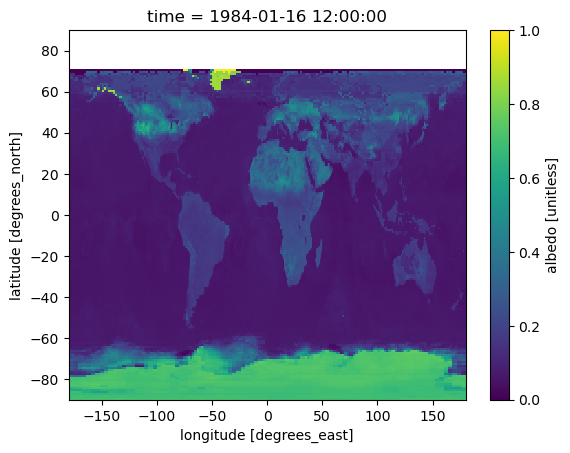

In [16]:
ds1_t0 = ds1.isel(time=0)
ds1_t0['albedo'].plot()

In [17]:
ds1

<xarray.Dataset> Size: 299MB
Dimensions:      (time: 288, nv: 2, lat: 360, lon: 720)
Coordinates:
  * time         (time) object 2kB 1984-01-16 12:00:00 ... 2007-12-16 12:00:00
  * lat          (lat) float32 1kB -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
  * lon          (lon) float32 3kB -179.8 -179.2 -178.8 ... 178.8 179.2 179.8
Dimensions without coordinates: nv
Data variables:
    time_bounds  (time, nv) object 5kB ...
    albedo       (time, lat, lon) float32 299MB ...
Attributes:
    creation_date:        Mon Jun 30 23:00:33 PDT 2014
    Conventions:          Please contact Prof. James Randerson (Email: jrande...
    source_file:          This product is generated from monthly 1 degree GEW...
    title:                derived GEWEX SRB Radiation
    Approach:             To obtain albedo from GEWEX SRB radiation data, I d...
    Temporal resolution:  monthly
    General information:  This product was derived from NASA GEWEX SRB radiat...
    Spatial resolution:   0.5x0.5 degree
    Derived data code:    http://redwood.ess.uci.edu/mingquan/www/ILAMB/Downl...